<div>
<img src="https://www.nsstc.uah.edu/public/rwade/lis-data/Logo_header_nasa_lis_sport_arset.png" width="10000"/>

</div>

# **Application of NASA SPoRT-Land Information System (SPoRT-LIS) Soil Moisture Data for Drought**
# Session 3 - Homework
Authors: Robert Junod & Ryan Wade

Jupyter Notebook and data can be obtained from:

https://github.com/NASAARSET/SPoRT-LIS

https://geo.ndc.nasa.gov/SPoRT/modeling/lis/


For this homework item, you will use this Jupyter notebook to explore the SPoRT-LIS data found at the links above. Note: You will use real-time data for this exercise.

Homework Objectives:

1) Set up the Python environment and install all necessary packages to readin, manipulate, and plot SPoRT-LIS GeoTIFF data files.

2) Readin SPoRT-LIS GeoTIFFs, create basic plots of Relative Soil Moisure (RSM) and Gridded Soil Moisure (VSM) Percentiles.

3) Create zoomed-in mulitpanel plots of soil moisture products at various depths for drought analysis.

4) Create international plots of soil moisture and soil moisture anomalies for drought analysis.


Final Deliverables:

Upload the following plots to the final course Google Form:

1) 4-panel plot of Gridded Soil Moisture (VSM) Percentiles zoomed-in to Nebraska/Kansas for the folowing depts: 0-10cm, 0-40cm, 0-100cm, & 0-200cm

2) Single 10-40cm Relative Soil Moisture (RSM) Difference from Mean (Anomaly) plot



# **Pre-Exercise Set-Up**

## <font color='red'> **Only run the following cell if you are using Google Colab** </font>
---

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy rioxarray
!apt-get -qq install python3-cartopy

!pip uninstall -y shapely    
!pip install shapely --no-binary shapely
#resolves conflicts between cartopy and shapely (issues since early 2020)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (7.2.1-1~focal0).
libproj-dev set to manually installed.
proj-data is already the newest version (7.2.1-1~focal0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 170 kB of archives.
After this operation, 485 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal/main amd64 proj-bin amd64 7.2.1-1~focal0 [170 kB]
Fetched 170 kB in 1s (247 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../proj-bin_7.2.1-1~focal0_amd64.deb ...
Unpacking proj-bin (7.2.1-1~focal0) ...
Setting up proj-bin (7.2.1-1~focal0) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists... Done
Building

## **Required Imports and Colorscale Function**
---

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from datetime import datetime as dt

import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

The color maps below have been hard-code defined to match the LIS color scales on the NASA SPoRT Viewer

In [ ]:
def get_LIS_cmap(output:str, file_str:str) -> ListedColormap:
  """ Make custom cmap, levels, and labels for LIS product
  
  Parameters
  ----------
  :param output: string defining the output product cmap
  :param file_str: string of input file to get labels

  Returns
  -------
  :returns: custom LIS cmap
  :returns: custom levels
  :returns: title string for plot
  
  """

  cdict = {'rsm': np.array(([0.549, 0.3922, 0.3529],
                           [0.7059, 0.549, 0.5098],
                           [0.8824, 0.7451, 0.7059],
                           [0.6471, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.1961, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.6275, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9098, 0.4706],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.0784, 0.3922, 0.8235],
                           [0.1569, 0.5098, 0.9412],
                           [0.3137, 0.6471, 0.9608],
                           [0.5882, 0.8235, 0.9804],
                           [0.6275, 0.549, 1.0],
                           [0.4392, 0.3765, 0.8627],
                           [0.2353, 0.1569, 0.7059])),
           'vsm': np.array(([0.7059, 0.549, 0.5098],
                           [0.902, 0.4392, 0.4392],
                           [0.6471, 0.0, 0.0],
                           [0.7529, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.1961, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.6275, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9098, 0.4706],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.1176, 0.4314, 0.9216],
                           [0.2353, 0.5882, 0.9608],
                           [0.4706, 0.7255, 0.9804])),
           'gvf': np.array(([0.4706, 0.3137, 0.2745],
                           [0.6275, 0.4706, 0.4314],
                           [0.7843, 0.6275, 0.5882],
                           [1.0, 0.9098, 0.4706],
                           [0.6275, 0.902, 0.1961],
                           [0.7059, 0.9804, 0.6667],
                           [0.4706, 0.9608, 0.451],
                           [0.2157, 0.8235, 0.2353],
                           [0.1176, 0.7059, 0.1176],
                           [0.0588, 0.6275, 0.0588])),
           'chg': np.array(([0.3922, 0.2353, 0.1961],
                           [0.549, 0.3922, 0.3529],
                           [0.7059, 0.549, 0.5098],
                           [0.8824, 0.7451, 0.7059],
                           [0.9725, 0.6275, 0.6275],
                           [0.6471, 0.0, 0.0],
                           [0.8824, 0.0784, 0.0],
                           [1.0, 0.3765, 0.0],
                           [1.0, 0.7529, 0.2353],
                           [1.0, 0.9804, 0.6667],
                           [0.7059, 0.7059, 0.7059],
                           [0.5882, 0.9608, 0.549],
                           [0.3137, 0.9412, 0.3137],
                           [0.1176, 0.7059, 0.1176],
                           [0.1176, 0.4314, 0.9216],
                           [0.2353, 0.5882, 0.9608],
                           [0.4706, 0.7255, 0.9804],
                           [0.7059, 0.9412, 0.9804],
                           [0.502, 0.4392, 0.9216],
                           [0.2824, 0.2353, 0.7843],
                           [0.1765, 0.1176, 0.6471])),
           'per': np.array(([0.4196,0.0000,0.0000],
                            [0.9216,0.0000,0.0000],
                            [0.9216,0.4588,0.0000],
                            [1.0000,0.7020,0.4000],
                            [1.0000,1.0000,0.4000],
                            [0.7843,0.7843,0.7843],
                            [0.8863,1.0000,1.0000],
                            [0.5961,0.8235,0.9765],
                            [0.3294,0.6510,0.9529],
                            [0.1882,0.5137,0.9294],
                            [29/255.,101/255.,207/255.]))
           }
  level_dict = {'rsm': np.arange(5,96,5),
                'vsm': np.arange(3,46,3),
                'gvf': np.array([10,20,30,40,50,60,70,80,90.]),
                'chg': np.array([-32, -28, -24, -20, -16, -12, -8, -4, -2, -0.1,
                                 0.1, 2, 4, 8, 12, 16, 20, 24, 28, 32]),
                'per': np.array([2,5,10,20,30,70,80,90,95,98])}


  _date = dt.strptime(file_str.split('/')[-1][:8],'%Y%m%d')
  _hour = dt.strptime(file_str.split('/')[-1][9:13],'%H%M')
  _product = file_str.split('/')[-2]
  _ptype = file_str.split('/')[-1].split('_')[4]


  title_dict = {'rsm': f'{_product} (available water; %) valid {_hour:%H}Z'
                       f'{_date:%m-%d-%Y}',
                'vsm': f'{_product} (%) valid {_hour:%H}Z {_date:%m-%d-%Y}',
                'gvf': f'Green Vegetation Fraction (%) valid {_date:%m-%d-%Y}',
                'chg': f'{" ".join(_product.split("_"))} Difference (%) valid '
                       f'{_hour:%H}Z {_date:%m-%d-%Y}',
                'per': f'Soil Moisure Percentile valid {_date:%m-%d-%Y}'}
  
  # Set cmap colorbar by product type
  # - set under, over, and bad values as well  
  _cmap = ListedColormap(cdict[output][1:-1])
  _cmap.set_bad(color=(1,1,1))
  _cmap.set_over(color=cdict[output][-1])
  _cmap.set_under(color=cdict[output][0])

  return _cmap, level_dict[output], title_dict[output]

# **Exercise 1: Readin NASA SPoRT LIS data and plot for CONUS, then create 4-panel zoomed-in plot**

 # **Drought Monitor Example - CONUS - 16-18 May 2023**

You are a drought monitor author who wants to create your own visualization of NASA SPoRT-LIS data. Your goal is to create a CONUS view (similar to the U.S. Drought Monitor maps) of Gridded Soil Moisture (VSM) Percentile for the 0-100cm layer to aid in your analysis. 

<div>
<img src="https://droughtmonitor.unl.edu/data/png/20230516/20230516_usdm.png" width="800"/>
</div>



You start by downloading & reading-in SPoRT-LIS data (GeoTIFF), specifically the 0-100cm VSM Percentile product from the NASA ARSET SPoRT-LIS Github repository: https://github.com/NASAARSET/SPoRT-LIS

("Live" data from NASA MSFC SPoRT's geo server:  https://geo.ndc.nasa.gov/SPoRT/modeling/lis/conus3km/geotiff/)

You will select the "vsm_percentiles" directory, then copy and paste the filename for the 0-100cm Gridded Soil Moisture (VSM) percentiles GeoTIFF for **2023-05-18** date for the "file_in" line below. 

You may also need to update the "geo_url" with the correct full path to the vsm_percentiles directory.

In [ ]:
geo_url = 'https://github.com/NASAARSET/SPoRT-LIS/raw/main/sample_data/conus/vsm_percentiles/'

# Gridded Soil Moisure (VSM) 0-100cm percentile
file_in = geo_url + 'XXXXXXXXX.tif'
ptype = 'per'

ds = rxr.open_rasterio(file_in) if ptype != 'vsm' else rxr.open_rasterio(file_in) * 100.
# Mask any nodata values
ds = ds.where(ds < 9999).copy()

> <font size=5> 🗒 **Note for Readin** </font>: 

Read in different LIS products a similar way by copy & pasting the sections for each product from below.

>```python
># VSM 0-10cm percentile  (Gridded Soil Moisture Percentile)
file_in = geo_url + '20220930_0000_sport_lis_vsm0-10cm_percentile_conus3km_float_wgs84.tif'
ptype = 'per'
```
>```python
># RSM 0-10cm  (Relative Soil Moisture)
file_in = geo_url + '20230130_0000_sport_lis_rsm0-10cm_conus3km_float_wgs84.tif'
ptype = 'rsm'
```
>```python
># VSM 0-10cm   (Gridded Soil Moisture)
file_in = geo_url + '20230501_0000_sport_lis_vsm0-10cm_conus3km_float_wgs84.tif'
ptype = 'vsm'
```
>```python
> # GVF   (Green Vegatation Fraction)
file_in = geo_url + '20230130_0000_sport_lis_gvf_conus3km_float_wgs84.tif'
ptype = 'gvf'
```
>```python
> # RSM 0-2m 14 day difference   (Relative Soil Moisture Difference)
file_in = geo_url + '20230130_0000_sport_lis_rsm0-2m_diff14day_conus3km_float_wgs84.tif'
ptype = 'chg'
```

### **Plot CONUS LIS Data**

Text(0.5, 1.0, 'Soil Moisure Percentile valid 05-18-2023')

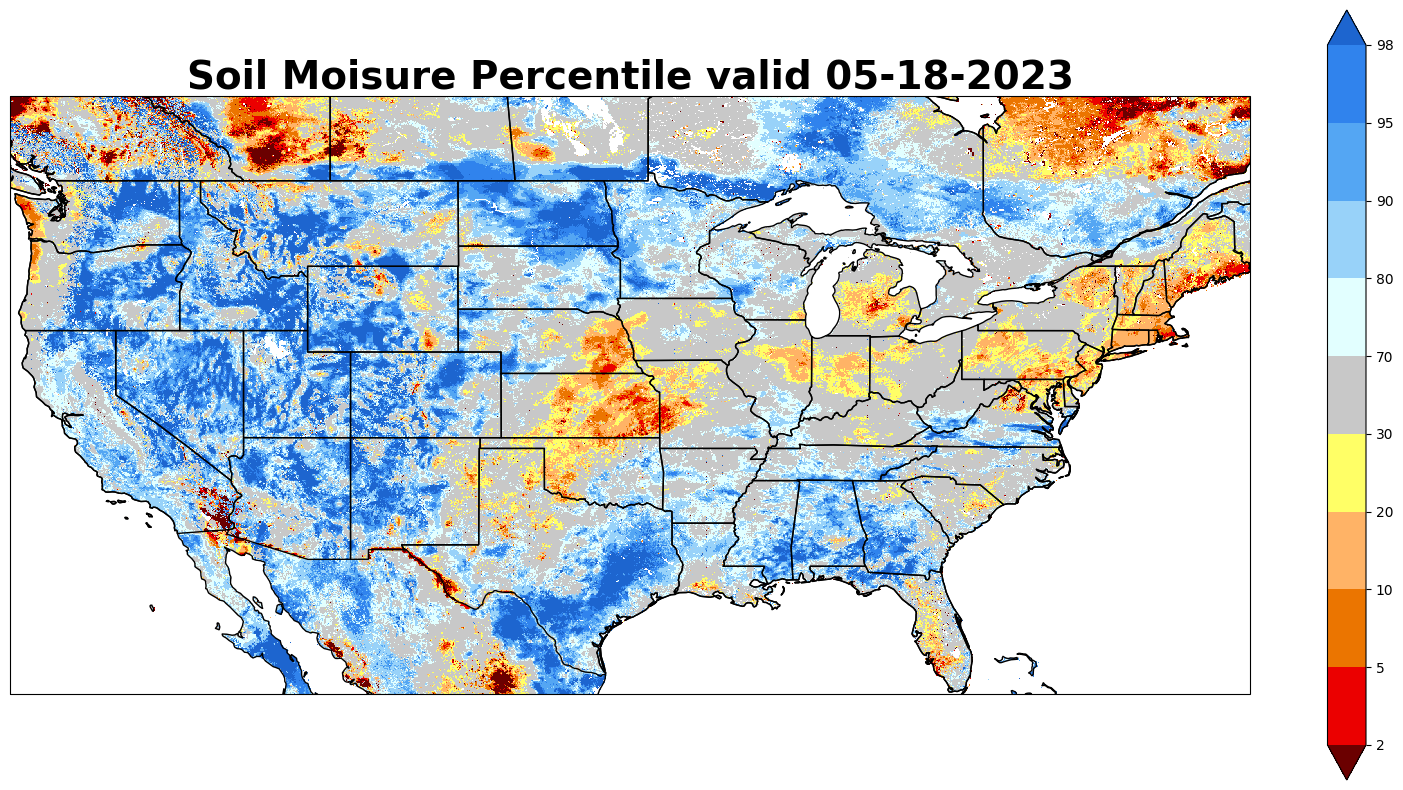

In [ ]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.STATES)
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

You notice the exceptionally dry soils for the on-going drought in the U.S. High Plains, so you want to create a zoomed-in view for the same region in the Drought Monitor map shown below for the U.S. states of North Dakoka, South Dakota, Wyoming, Colorado, Nebrask, and Kansas:

<div>
<img src="https://droughtmonitor.unl.edu/data/png/20230516/20230516_high_plains_trd.png" width="800"/>
</div>

First, you will need to download and readin county-based shapefiles for the United States. 


In [ ]:
#download and readin U.S. county shapefile for use in state-leve zoom
reader = shpreader.Reader('https://www.nsstc.uah.edu/public/rwade/lis-data/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cf.ShapelyFeature(counties, ccrs.PlateCarree())

Create plot, set color map, overlay coastlines and county boundaries onto previously readin SPoRT LIS Gridded Soil Moisture (VSM). 

Set the custom bounds for zoomed-in view based on latitutes 36N to 50N, longitudes 112W to 94W. 

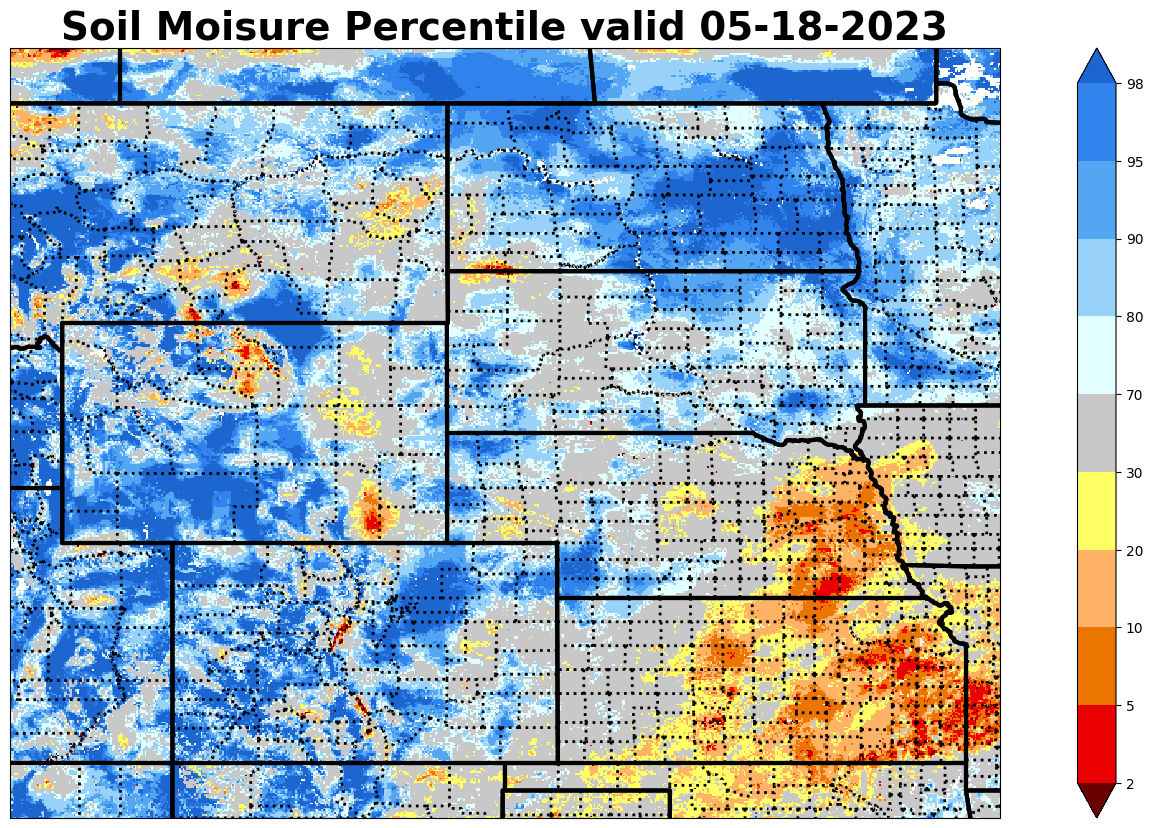

In [ ]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})

ax.coastlines()
ax.add_feature(cf.STATES, linewidth=3)
ax.add_feature(COUNTIES, linestyle=':', linewidth=2, facecolor='none', edgecolor='black')
ax.set_title(label=tlabel, fontdict={'fontsize': 28,'fontweight': 'bold'})

#set custom bounds for plot
ax.set_extent([lon-w,lon-e,lat-s,lat-n])

# Create a 4-Panel plot for available SPoRT-LIS Gridded Soil Moisture depths

You realize that you really need to more fully examine the D3 (Extreme) to D4 (Exceptional) Drought in Nebraska and Kansas. You decide you both need to zoom-in to Nebraska/Kansas, and create a 4-panel of Gridded Soil Moisture (VSM) percentiles moisture depth for drought impacts, you decide to set up a 4-panel plot of the following products: 

0-10cm Gridded Soil Moisture (VSM) Percentiles

0-40cm Gridded Soil Moisture (VSM) Percentiles

0-100cm Gridded Soil Moisture (VSM) Percentiles

0-200cm Gridded Soil Moisture (VSM) Percentiles

Download data for the VSM 0-10cm, 0-40cm, 0-100cm, & 0-200cm depths. 

Note: you will need to change the date to match the VSM Percentile files for this case. 

In [ ]:
# For panel plot for percentiles
per_depths = ['10cm','40cm','100cm','200cm']
files = [f'{geo_url}20210930_0000_sport_lis_vsm0-{depth}_percentile_conus3km_float_wgs84.tif' for depth in per_depths]
lis_dict = {'per_'+k:rxr.open_rasterio(file) for (k,file) in zip(per_depths,files)}

Define a dictionary (look-up table) for LIS data inputs and products for the 4-panel plot.

Note: you will need to change the lat/lon bounds to zoom-in to Nebraska/Kansas.

In [ ]:
def panel_plot(lis_dict:dict, _ptype:str, _files:list, counties) -> str:
  """ Make four panel plot from LIS data
  
  Parameters
  ----------
  :param lis_dict: dictionary of lis data inputs
  :param _ptype: string of LIS product type
  :param _files: list of files of _ptype

  Returns
  -------
  :returns: string of success
  
  """

  # Checks to make sure there are only 4 data inputs
  assert len(lis_dict.keys()) == 4, 'Incorrect number of data inputs, try again!'

  fig, ax = plt.subplots(figsize=(12,10), nrows=2, ncols=2,
                           subplot_kw={'projection':ccrs.PlateCarree()})

  for i,data in enumerate(lis_dict.keys()):
    _data = lis_dict[data].where(lis_dict[data] < 9999).copy()
    _cmap, _levels, _tlabel = get_LIS_cmap(_ptype, _files[i])
    map = _data.squeeze().plot(ax=ax[i//2,i%2], transform=ccrs.PlateCarree(), cmap=_cmap,
                              norm= BoundaryNorm(_levels, _cmap.N),
                              add_colorbar=False)
    ax[i//2,i%2].coastlines()
    ax[i//2,i%2].add_feature(cf.STATES, linewidth=3)
    ax[i//2,i%2].add_feature(counties, linestyle='solid', linewidth=1, facecolor='none', edgecolor='black')
    ax[i//2,i%2].set_title(label=_tlabel, fontdict={'fontsize': 12,'fontweight': 'bold'})
    
    #set custom bounds for plot here! (lon1, lon2, lat1, lat2)
    ax[i//2,i%2].set_extent([lon-w,lon-e,lat-s,lat-n])

  cax = fig.add_axes([0.95,0.10,0.03,0.75])
  cbar = fig.colorbar(map, cax=cax,orientation='vertical',
                      label='Percentile (% of volume)', extend='both', ticks= _levels)
  
  return 'Plot Success!'
  





Execute the 4-panel plot:

'Plot Success!'

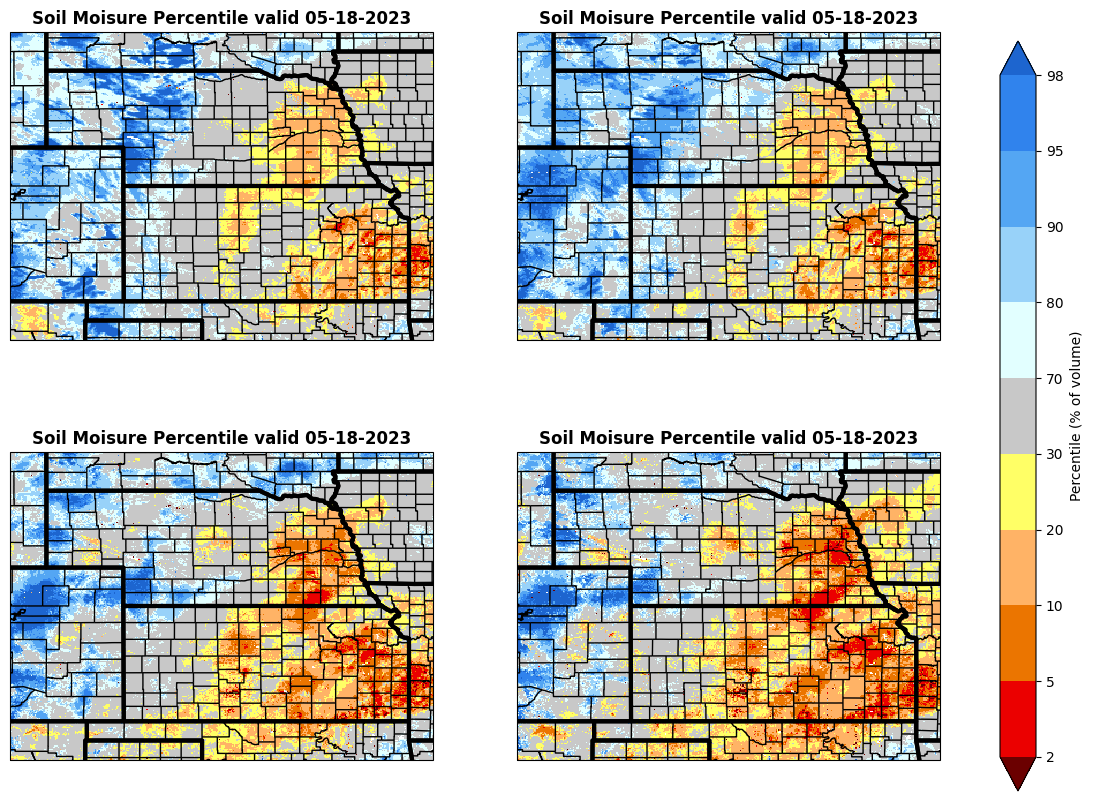

In [ ]:
# Panel plot
panel_plot(lis_dict,'per',files, COUNTIES)

**Save and upload the 4-panel plot above to the "End of Course Homework Quiz" in the "Session 3" section.**

# **Exercise 2: Readin NASA SPoRT LIS data and plot for Africa, then create a soil moisture anomaly zoomed in plot**

### **Step 1: Plot Africa LIS Data**

You are interested in creating Relative Soil Moisture (RSM) plots for all of Africa, and you want to see how this compares to the mean for some time period.

Step 1: Readin RSM data for Africa for **2021-11-01**

Note: Be sure to change the "geo_url" and "file_in" to the appropriate data directory & desired data file.

In [ ]:
geo_url = 'https://github.com/NASAARSET/SPoRT-LIS/raw/main/sample_data/africa/'

# RSM 10-40cm
file_in = geo_url + 'rsm10-40cm/XXXXXXXX_0000_sport_lis_rsm10-40cm_allafrica_3km_float_wgs84.tif'
ptype = 'rsm'


ds = rxr.open_rasterio(file_in) if ptype != 'vsm' else rxr.open_rasterio(file_in) * 100.
# Mask any nodata values
ds = ds.where(ds < 9999).copy()

Create Relative Soil Moisture data plot

Note: Be sure to change the ax.set_title label for appropriate date.

Text(0.5, 1.0, 'Relative Soil Moisture (%) valid 11-01-2021')

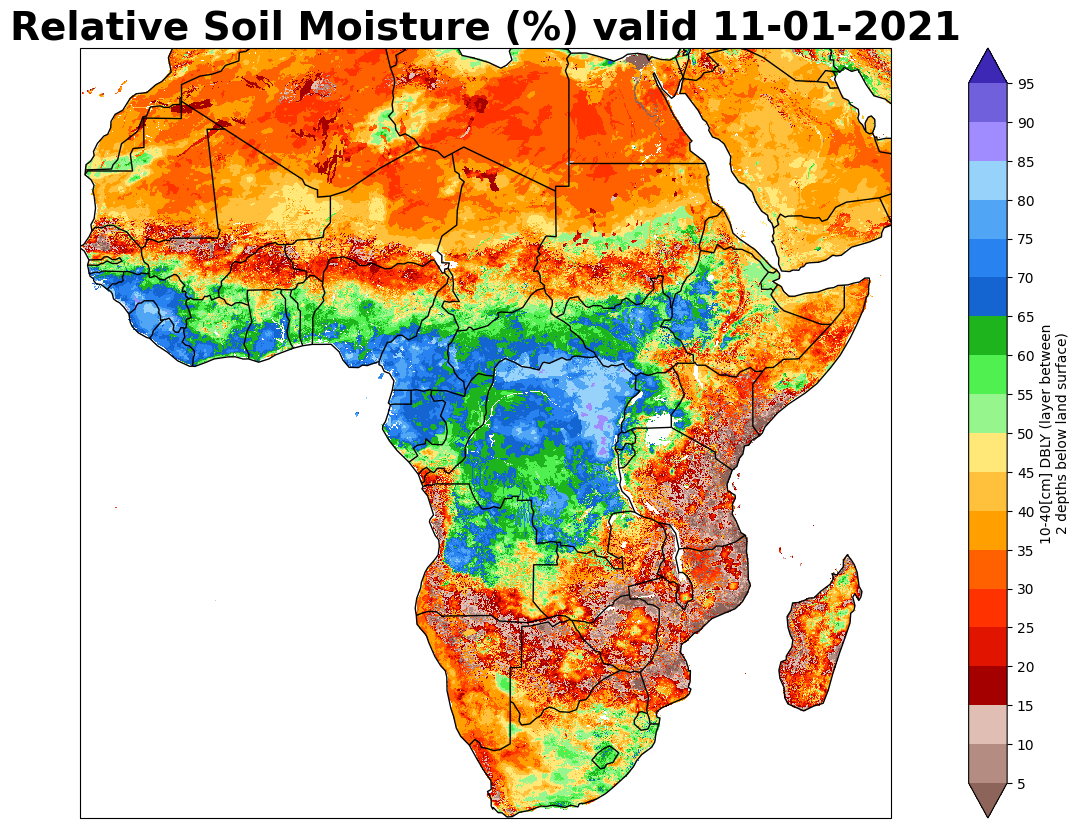

In [ ]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(label='Relative Soil Moisture (%) valid XX-XX-XXXX', fontdict={'fontsize': 28,'fontweight': 'bold'})

### **Step 2: Create Difference (Anomaly from 6-Year Mean) Plot**

Relative Soil Moisture Monthly Means have been created for all of Africa for a 6-year period and posted at:
https://github.com/NASAARSET/SPoRT-LIS/tree/main/sample_data/africa/monthly_means

You will create a custom difference plot for your the Africa file plotted above from the specific monthly mean (file _01 = January, _02 = February, etc).  Remeber to change your product type to 'chg' for this portion of the exercise.



Readin data for a RSM Difference (anomaly from 6-year mean) plot:

Note: Be sure to change the "geo_url" and "file_in" to the appropriate data directories & desired data files.

In [ ]:
geo_url = 'https://github.com/NASAARSET/SPoRT-LIS/raw/main/sample_data/africa/'

#RSM 10-40cm file 1 (specific RSM Africa file from Exercise 2 - Step 1)
file_in1 = geo_url + 'rsm10-40cm/XXXXXXXX_0000_sport_lis_rsm10-40cm_allafrica_3km_float_wgs84.tif'
ptype = 'rsm'

ds1 = rxr.open_rasterio(file_in1) if ptype != 'vsm' else rxr.open_rasterio(file_in1) * 100.
# Mask any nodata values
ds1 = ds1.where(ds1 < 9999).copy()


#RSM 10-40cm file 2 (the appropriate montly mean file) 
file_in2 = geo_url + 'monthly_means/LIS_allafrica_rsm_10_40cm_monthly_mean_XX.tif'
ptype = 'rsm'


ds2 = rxr.open_rasterio(file_in2) if ptype != 'vsm' else rxr.open_rasterio(file_in2) * 100.
# Mask any nodata values
ds2 = ds2.where(ds2 < 9999).copy()

Plot the RSM Montly Mean for specified month:

Note: Be sure to change the ax.set_title label for the appropriate date to match the data file.

Text(0.5, 1.0, 'Monthly Mean Relative Soil Moisture: November')

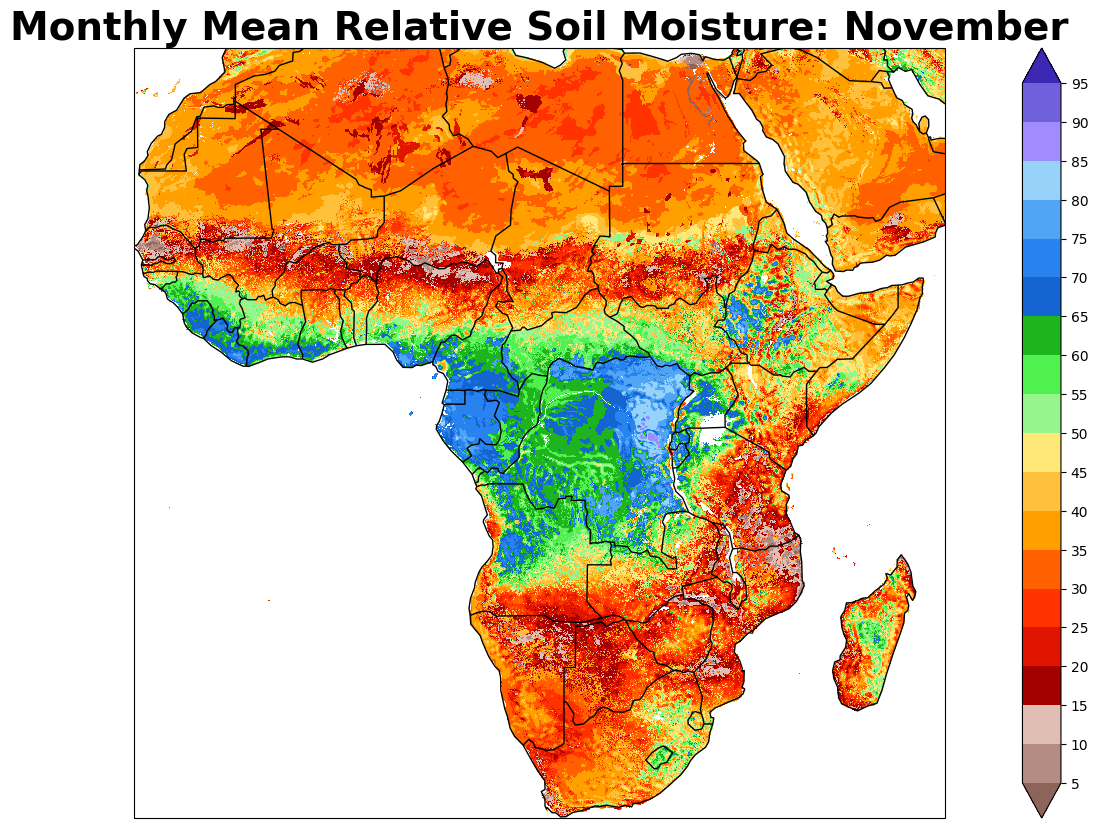

In [ ]:
cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds2.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(label='Monthly Mean Relative Soil Moisture: XXXXXXXXX', fontdict={'fontsize': 28,'fontweight': 'bold'})

Create a RSM Anomaly plot for 01-Nov-2021:

Note: Be sure to change the ax.set_title label for the appropriate date to match the data file. Also, change the ax.set_extent lat/lon bounds for a zoomed-in view (not required, just an option).

Text(0.5, 1.0, 'RSM Difference from Mean (Anomaly) valid 11-01-2021')

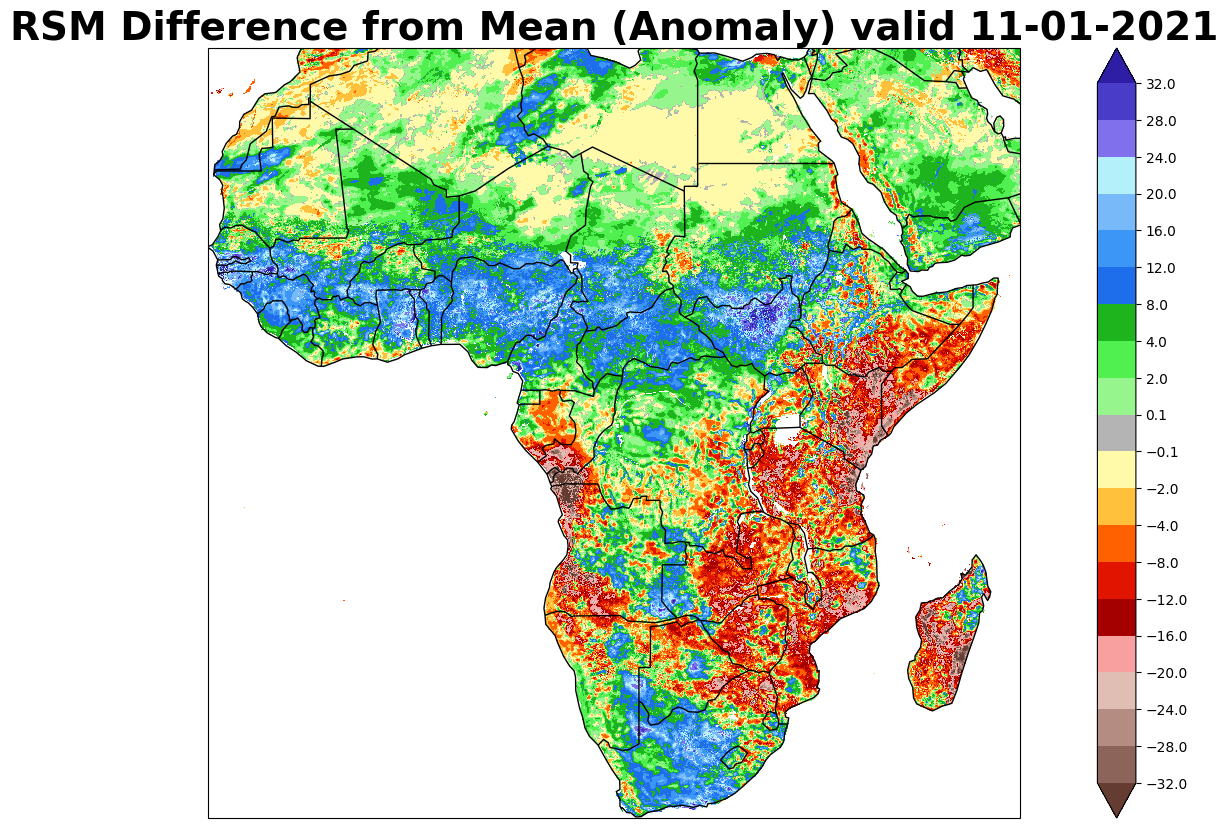

In [ ]:
ds3 = ds1 - ds2
ptype = 'chg'

cmap_LIS, levels, tlabel = get_LIS_cmap(ptype, file_in1)
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})
map = ds3.squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap_LIS,
                        # vmin=10, vmax=90,
                        norm= BoundaryNorm(levels, cmap_LIS.N),
                        extend='both',
                        cbar_kwargs={'ticks': levels})
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_title(label='RSM Difference from Mean (Anomaly) valid XX-XX-XXXX', fontdict={'fontsize': 28,'fontweight': 'bold'})

#set custom bounds for plot
#ax.set_extent([22,53,-22,21])

You should have a difference plot showing the departure from average for 01-Nov-2021 (anomaly). You can now upload your final images to the Google Form.

**Save and upload the Difference/Anomaly plot above to the "End of Course Homework Quiz" in the "Session 3" section.**